# Session 3: homework

# Chi-squared test for independence: Exercise social

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import statsmodels.api as sm

## Loading and inspecting the data

Load the file "social.tsv"

In [2]:
social = pd.read_csv("../../datasets/social/social.tsv", sep="\t")
social

,subject_ID,gender,education,language,parents_class
0,1,female,technical,Dutch_only,1
1,2,male,general,Dutch_only,1
2,3,female,general,Dutch_only,1
3,4,female,general,Dutch_only,1
4,5,female,technical,Dutch_only,1
...,...,...,...,...,...
395,396,female,technical,Dutch_only,2
396,397,male,vocational,Dutch_only,2
397,398,female,general,Dutch_and_other,2
398,399,female,vocational,Dutch_only,2


Before we proceed, we are going to condense the `parents_class`: instead of working with 7 class levels, we will continue with 3.
You are given the code for this operation:

In [3]:
# REMINDER: type hints ( x: int and -> str) are only hints, they are for *you* to make the code
# clearer. They are not required but they're a good habit.
def relevel(x: int) -> str:
    if x < 3:
        return "upper"
    if x < 6:
        return "middle"
    if x < 8:
        return "working"
    # If we haven't returned by now things have gone wrong
    raise ValueError(f"Unknown class level {x}")


social["parents_class"] = social.parents_class.apply(relevel)
social

,subject_ID,gender,education,language,parents_class
0,1,female,technical,Dutch_only,upper
1,2,male,general,Dutch_only,upper
2,3,female,general,Dutch_only,upper
3,4,female,general,Dutch_only,upper
4,5,female,technical,Dutch_only,upper
...,...,...,...,...,...
395,396,female,technical,Dutch_only,upper
396,397,male,vocational,Dutch_only,upper
397,398,female,general,Dutch_and_other,upper
398,399,female,vocational,Dutch_only,upper


##### Question: 
> Verify the data independence assumption of the chi-squared test. Are there repeated measurements in the data, i.e. >1 observation for 1 subject? What are the implications for your test?

> Using whichever method you choose, verify that `subject_ID` is unique

In [4]:
social.subject_ID.is_unique

True

##### Answer: 
> Each subject only occurs once in the dataset: unique observations for unique subjects. This is important information: we can go ahead and use a chi-squared test!

## Data exploration

Can we observe a correlation between the teenagers' educational track (variable `education`) and their parents' social class (variable `parents_class`)? Create a table with row percentages and one with column percentages. Round the percentages to two digits.

In [5]:
pd.crosstab(social.education, social.parents_class, normalize="index").round(2)

parents_class,middle,upper,working
education,,,
general,0.36,0.59,0.05
technical,0.48,0.33,0.19
vocational,0.40,0.17,0.42


In [6]:
pd.crosstab(social.education, social.parents_class, normalize="columns").round(2)

parents_class,middle,upper,working
education,,,
general,0.33,0.58,0.09
technical,0.35,0.27,0.26
vocational,0.33,0.15,0.64


##### Question:
> How do you intuitively interpret these tables?

##### Answer:
> **row percentages:** Most general education students' parents have an upper class profile, most technical education students' parents have a middleclass profile and most vocational education students' parents have a workingclass or middleclass profile

> **column percentages:** The majority of upperclass parents' kids are in general education, while the majority of workingclass parents' kids are in vocational education. Middleclass parents' kids are more or less evenly distributed among the three educational tracks.

## Data visualization

Create the appropriate categorical plot for education versus parents' class. You will need to import the correct library (we 'forgot' to do it for you above). Visualize once "by parents' class" (on the x-axis) and once "by education"

In [7]:
from statsmodels.graphics.mosaicplot import mosaic

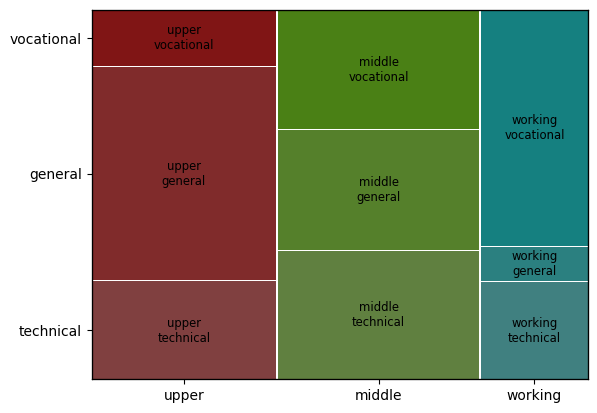

In [8]:
mosaic(social, ["parents_class", "education"])
plt.show()

##### Interpretation:
> The plot tells us the same as the table, but in a visual way: the number of kids with upperclass parents decreases as the kids' educational track becomes more practice-oriented, while the number of kids with workingclass parents increases as the educational track becomes more practice-oriented. 
Most upperclass parents' kids are in general (the most theory-oriented) education, while most workingclass parents' kids are in vocational (the most practice-oriented) education. Finally, we see that parental class is a bit more evenly distributed for students in the hybrid technical education (with middleclass being the most frequent level), and that middleclass parents' kids are quite evenly distributed among the three main educational tracks in secondary school.

## Chi-squared test for independence

Now perform a chi-squared test for independence for the teenagers' educational track and the parents' social class (conflated).

Start by formulating your null hypothesis and alternative hypothesis.

##### Answer:
> $H_0$ = there is no correlation between the parents' class and the teenagers' education. The frequencies per educational track do not depend on class or vice versa.

> $H_1$ = there is a significant correlation between class and education. 

Perform a chi-squared for independence using `chi2_contingency` and interpret the results. Remember to use the `crosstab` with **raw counts** not normalized values. You will need to verify the key assumption. Revise the notebooks if you need to.

In [9]:
obs = pd.crosstab(social.education, social.parents_class)

res = sp.stats.chi2_contingency(obs)
if (res.expected_freq > 5).all():
    print("Expected counts OK")
    print(f"Chisq: Stat: {res.statistic}, p-value: {res.pvalue}")
else:
    print("Expected count(s) too small, aborting.")

Expected counts OK
Chisq: Stat: 79.34677451072628, p-value: 2.3953952183055235e-16


##### Question:
> How to interpret this result?

##### Answer:
> The p-value (<0.05) indicates that the chi-squared value is larger than the critical value (for df = 4) necessary for the observed and expected frequencies to be significantly different. So, on the basis of this chi-squared test, we can reject $H_0$ that education and parental class are not correlated, and say that there is a statistically significant correlation between the two. Recall that, **since the chi-squared test is a non-directional test, we cannot say anything about causality**!

## Measures of effect size

Since the chi-squared valued and the $p$-value are dependent on sample size, provide a measure of effect size too.

As we can only calculate odds ratios for pairs, and both our variables have three (and not two) levels, you only need to calculate Cramer's V (i.e. chi-squared value normalized for sample size). Recall the formula:

> Cramer's V = $\sqrt{\frac{X^2}{n * (min(nrow,ncols) -1)}}$

In which *n* is the sample size. To obtain the number of rows and columns, either just look at your table, or apply `shape` to it (to the table, not the entire dataset!). Finally, to obtain your chi-squared value again, either copy it from your output, or retrieve it directly from `chi2_contingency` with `.statistic`.

Alternatively, use a different scipy method to directly output Cramer's V.

In [10]:
# By hand:
np.sqrt(res.statistic / (social.shape[0] * (min(obs.shape) - 1)))

0.3149340695104419

In [11]:
# Faster:
sp.stats.contingency.association(obs, method="cramer")

0.3149340695104419

##### Intuitive interpretation:
> As Cramer's V ranges between 0 and 1 (with 1 = perfect correlation and 0 = no correlation), the obtained score is not extremely high. However, it already is a lot larger than e.g. the score for the correlation we saw in the class exercise (submission size vs gender).

## Chi-squared test for independence (additional exercise): Home language

Repeat the analyses above for a potential correlation between teenagers' educational track and the language they speak at home (variable: 'language'). Start by turning the language variable into an ordered factor. You are given the code for this operation:

Inspect the table (with row and then column percentages).

In [12]:
pd.crosstab(social.education, social.language, normalize="index").round(2)

language,Dutch_and_other,Dutch_only,other_only
education,,,
general,0.08,0.91,0.01
technical,0.11,0.87,0.02
vocational,0.21,0.74,0.05


In [13]:
pd.crosstab(social.education, social.language, normalize="columns").round(2)

language,Dutch_and_other,Dutch_only,other_only
education,,,
general,0.23,0.40,0.1
technical,0.25,0.31,0.3
vocational,0.53,0.29,0.6


##### Interpretation:
> **row percentages:** The majority of students in all educational tracks only speak Dutch at home. However, the more practice-oriented the track is, the more students speak another language too ('Dutch_and_other'), or only another language ('other_only').

> **column percentages:** The majority of the 'Dutch_only' kids are in general education, while the majority of 'Dutch_and_other' and especially 'other_only' kids are in vocational education.

Visualize with an appropriate plot, but only bother with education on the x-axis.

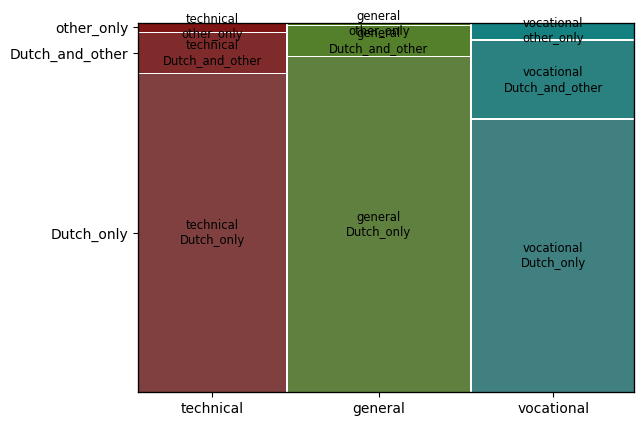

In [14]:
mosaic(social, ["education", "language"])
plt.show()

##### Plot interpretation:
> Same as table interpretation. The vast majority of all students only speak Dutch at home. However, the number of kids only speaking Dutch at home slightly decreases as the educational track becomes more practice-oriented, while the number of kids speaking another language too, or only another language, increases.
The majority of 'Dutch_only' kids are in the general track, whereas most 'Dutch_and_other' and especially 'other_only' kids are in the vocational track.

Now perform a chi-squared test for independence and describe your interpretation. Make sure to validate the key assumptions.

In [15]:
obs = pd.crosstab(social.education, social.language)
print(obs)

res = sp.stats.chi2_contingency(obs)
if (res.expected_freq > 5).all():
    print("Expected counts OK")
    print(f"Chisq: Stat: {res.statistic}, p-value: {res.pvalue}")
else:
    print("Expected count(s) too small, aborting.")

language    Dutch_and_other  Dutch_only  other_only
education                                          
general                  12         135           1
technical                13         104           3
vocational               28          98           6
Expected count(s) too small, aborting.


##### Answer:
> The expected counts in some cells are too small to be reliable! **As a rule of thumb, all *expected* counts should be larger than 5.**

##### Question:
> Can you think of a creative solution that would allow you to apply a chi-squared test for independence here? Hint: think of what we did to the original parents' class variable.
##### Answer:
> A potential solution here would be e.g. to combine the "Dutch_and_other" and "other_only" levels. Because we can see that the *observed* cells for these variables are super small as well... And an increase in observed counts often leads to an increase in expected counts too.

In [16]:
obs["Not_Dutch_only"] = obs.Dutch_and_other + obs.other_only
obs2 = obs[["Dutch_only", "Not_Dutch_only"]].copy()
obs2

language,Dutch_only,Not_Dutch_only
education,,
general,135,13
technical,104,16
vocational,98,34


In [17]:
print(obs2)

res = sp.stats.chi2_contingency(obs2)
if (res.expected_freq > 5).all():
    print("Expected counts OK")
    print(res.expected_freq)
    print(f"Chisq: Stat: {res.statistic}, p-value: {res.pvalue}")
else:
    print("Expected count(s) too small, aborting.")

language    Dutch_only  Not_Dutch_only
education                             
general            135              13
technical          104              16
vocational          98              34
Expected counts OK
[[124.69  23.31]
 [101.1   18.9 ]
 [111.21  20.79]]
Chisq: Stat: 15.903544686927475, p-value: 0.00035203767971022005


Now we do get a valid output! Education and language are significantly correlated.

> #### HARD: one more thing...

If you managed to find a solution, calculate the critical value for $p \lt 0.05$ for the $\chi^2$ *statistic* for that test. You will need to work out the correct number of degrees of freedom according to the number of rows and columns, or find it somewhere (hint: check the `Chi2ContingencyResult` object returned by the test). To calculate the statistic you will need the *inverse survival function* for the $\chi^2$ distribution.

HINT: you should have a number bigger than 2 and smaller than 20. ;)

In [18]:
# DOF for contingency test is (nrows-1) * (ncol-1) = 2 x 1
dof = res.dof
thresh = 0.05
print(
    f" critical value for p < {thresh} at {dof} degrees of freedom is {sp.stats.chi2.isf(thresh, df=dof):.3f}"
)

 critical value for p < 0.05 at 2 degrees of freedom is 5.991


```
Version History

Current: v1.0.1

7/10/24: 1.0.0: first draft, BN
08/10/24: 1.0.1: proofread, MK
```